# Read Auxtel spectra with pickles and fit GP 

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : January 15th  2022


- **kernel anaconda3_auxtel** at CC or **python 3** locally

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,WhiteKernel, ConstantKernel, Matern



In [4]:
# Increase the number of iteration inside the GaussuanProcessRegressor
#https://stackoverflow.com/questions/62376164/how-to-change-max-iter-in-optimize-function-used-by-sklearn-gaussian-process-reg
from sklearn.utils.optimize import _check_optimize_result
class MyGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=2e05, gtol=1e-06, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol

    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter, 'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min

In [5]:
import pickle

In [6]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [7]:
from datetime import datetime,date

In [8]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [9]:
string_date

'2022-01-15'

In [10]:
from astropy.io import fits
from scipy import ndimage, misc
from scipy.interpolate import interp1d

In [11]:
from time import sleep

In [12]:
from astropy.time import Time
import astropy.units as u

In [13]:
WL=np.arange(350,1100,2)
NWL=len(WL)
X = WL[:,None]

# Function

In [14]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^holo4_003_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target(filename):
    m = re.findall('^holo4_003_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

In [15]:
def file_tag_forsorting_ronchi(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^ronchi170lpmm_.*_(.*)_quickLookExp.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

def file_target_ronchi(filename):
    m = re.findall('^ronchi170lpmm_.*_(.*)_.*_.*_quickLookExp$', filename)
    if len(m)>0:
        return m[0]
    else:
        return None

# Config

In [16]:
DATE="2021-07-07"
DATE2="2021_07_07"

In [17]:
version="v4.0"

# Path

In [18]:
inputfilename="./data/holo-scan-auxtel.pickle"

# Read file

In [19]:
with open(inputfilename, 'rb') as pickle_file:
    data_dict = pickle.load(pickle_file)

In [20]:
# data_dict.keys()

In [21]:
list_of_filenames = sorted(data_dict.keys())

In [22]:
# data_dict.values()

In [23]:
#for item in data_dict.items():
#...     print(item)

In [24]:
item = data_dict[list_of_filenames[0]]

In [25]:
len(item['all_lambdas'])

914

In [26]:
len(item['all_fluxes'])

914

In [27]:
N=len(list_of_filenames)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

 bad holo4_003_empty_HD160617_20210707_000276_quickLookExp_spectrum.fits
 bad holo4_003_empty_HD160617_20210707_000284_quickLookExp_spectrum.fits
 bad holo4_003_empty_HD160617_20210707_000289_quickLookExp_spectrum.fits
 bad holo4_003_empty_HD160617_20210707_000291_quickLookExp_spectrum.fits


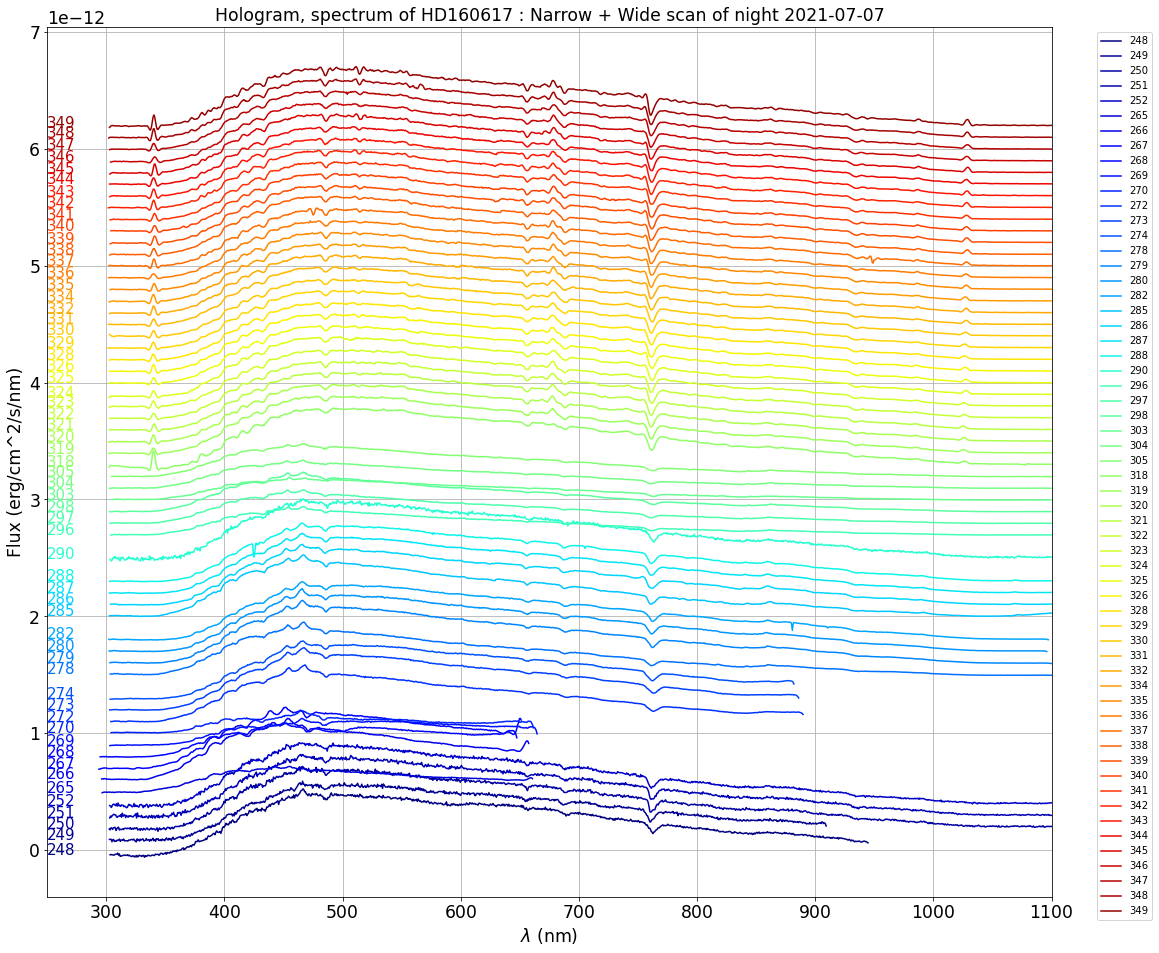

In [28]:
fig=plt.figure(figsize=(18,16))
ax=fig.add_subplot(1,1,1)

idx=0
for filename in list_of_filenames:
    
         
    item  = data_dict[filename]
    lambdas = np.array(item['all_lambdas'])
    fluxes  = np.array(item['all_fluxes'])
    label = int(item['number'])
    
    
    
    delta=idx*1.0e-13
    #delta=0
    
    if len(lambdas) == len(fluxes) and label not in [284, 276, 289, 291] :
        try:
            ax.plot(lambdas,fluxes+delta,label=label,color=all_colors[idx])
            ax.text(250.,fluxes[0]+delta, f'{label}',color=all_colors[idx],fontsize=15)
        except TypeError:
            pass
    else:
        print(f" bad {filename}")
    
    idx+=1
ax.set_xlabel("$\\lambda$ (nm)")
ax.set_ylabel("Flux (erg/cm^2/s/nm)")
ax.set_xlim(250.,1100)
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), prop={'size': 10}, loc='upper left')
ax.set_title("Hologram, spectrum of HD160617 : Narrow + Wide scan of night 2021-07-07")
plt.show()
    

# Gaussian process with scikit learn

In [61]:
def fitGPSpectrum(wl,spec,specerr,errorfactor=1,flag_fixnoise=False):
    
    
    wl=np.array(wl)
    spec=np.array(spec)
    specerr=np.array(specerr)*errorfactor
    
    N=len(wl)
    
    #kernel = 1 * RBF(length_scale=33.0, length_scale_bounds=(1e-1, 1e3))    
    kernel = 1e-12 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 1e3), nu=1.5) + WhiteKernel(noise_level=1.e-12, noise_level_bounds=(1e-13, 1e-12))
    
    gaussian_process = GaussianProcessRegressor(kernel=kernel, alpha=specerr ** 2, n_restarts_optimizer=0)
    #gaussian_process = MyGPR(kernel=kernel, alpha=eeff ** 2, n_restarts_optimizer=9)
    
    X_train = wl.reshape((N,1))
    y_train = spec
    
    X = WL.reshape((NWL,1))
    
    gaussian_process.fit(X_train, y_train)
    
  
    
    mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    
    return mean_prediction, std_prediction, gaussian_process.kernel_



    
    

In [62]:
def plotfitGPSpectrum(wl,spec,specerr,errorfactor=1,ax=None):
    
    mean_prediction, std_prediction, kparams  = fitGPSpectrum(wl,spec,specerr,errorfactor=errorfactor)
    
    if ax == None:
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(1,1,1)
        
    ax.errorbar(wl,spec,yerr=specerr*errorfactor,marker="o",ecolor="k",color="r",label="Observations")
    ax.plot(WL, mean_prediction, label="Mean prediction")
    ax.fill_between(
        WL,
        mean_prediction - 1.96 * std_prediction,
        mean_prediction + 1.96 * std_prediction,
        alpha=0.5,
        label=r"95% confidence interval",color="cyan"
    )
    ax.legend()
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("spectrum")
    ax.set_title(f"GP regression on spectrum at position {idx_sel}")
    ax.set_ylim(0.,1e-12)
    
    

In [32]:
idx_sel =0
ERRORFACTOR = 10.0

In [33]:
item  = data_dict[filename]
lambdas = np.array(item['all_lambdas'])
fluxes  = np.array(item['all_fluxes'])
fluxes_err = np.array(item['all_fluxes_err'])
label = int(item['number'])   

<ErrorbarContainer object of 3 artists>

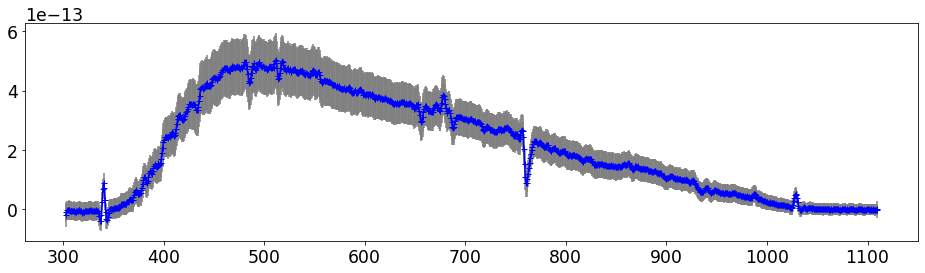

In [34]:
plt.errorbar(lambdas,fluxes,yerr=fluxes_err*ERRORFACTOR,marker="+",color="b",ecolor="grey")

In [58]:
mean, Cov ,k  = fitGPSpectrum(lambdas,fluxes,fluxes_err,errorfactor=ERRORFACTOR)

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

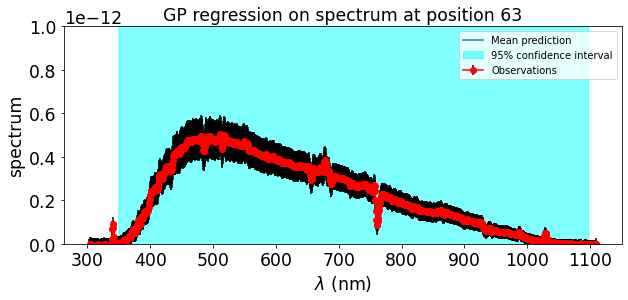

In [59]:
plotfitGPSpectrum(lambdas,fluxes,fluxes_err,errorfactor=ERRORFACTOR,ax=None)

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/Users/dagoret/anaconda3/lib/python3.8/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-13. Decreasing the bound and calling fit again may find a better value.
  war

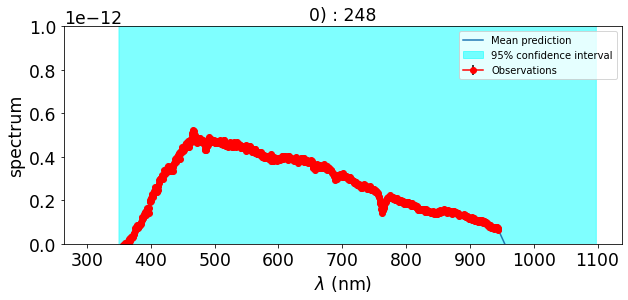

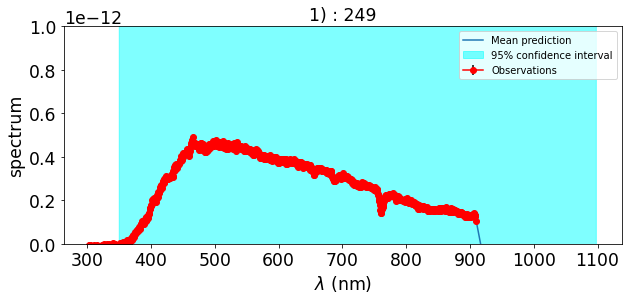

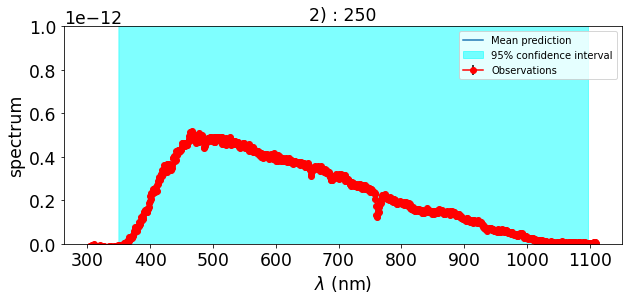

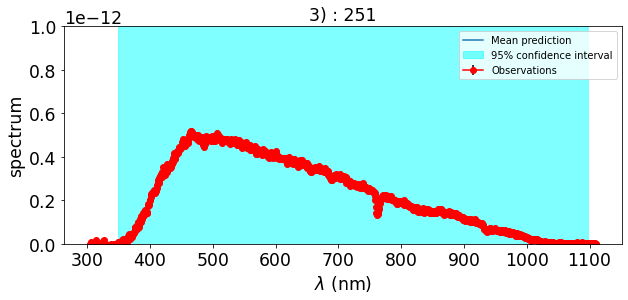

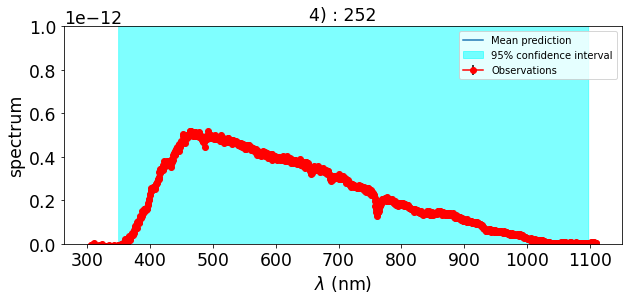

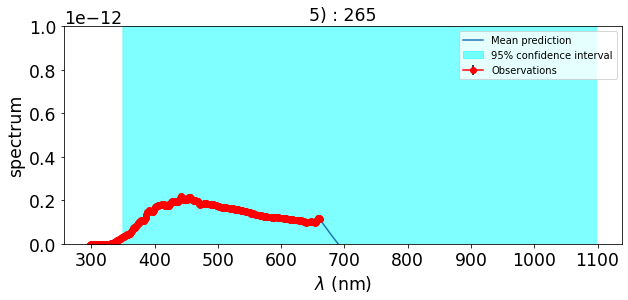

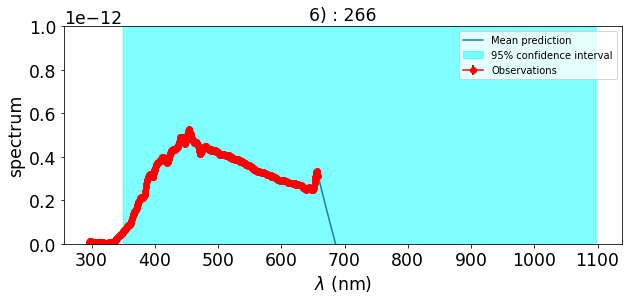

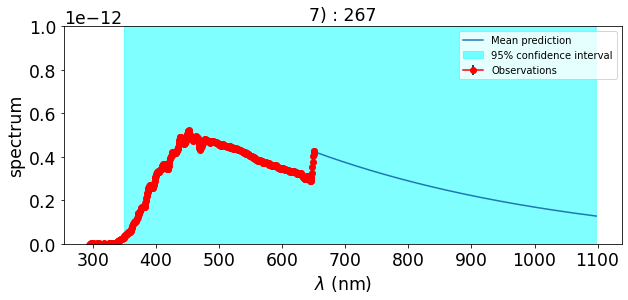

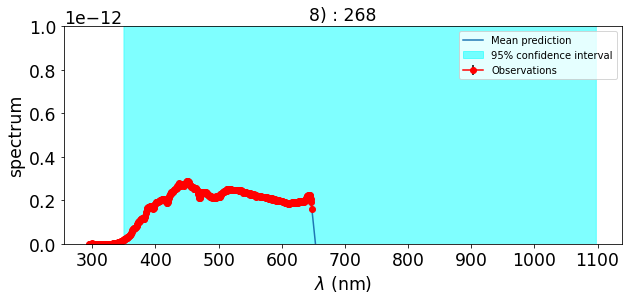

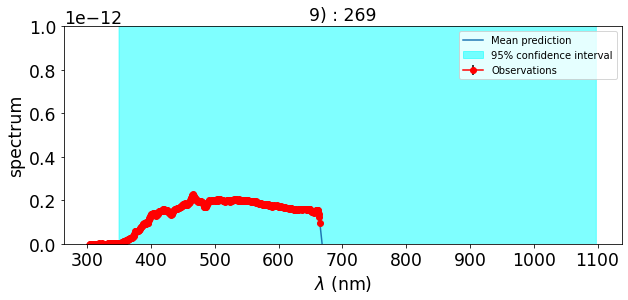

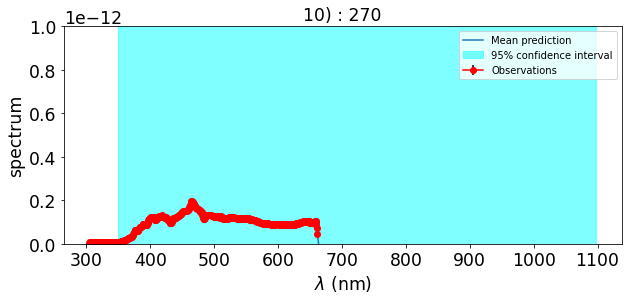

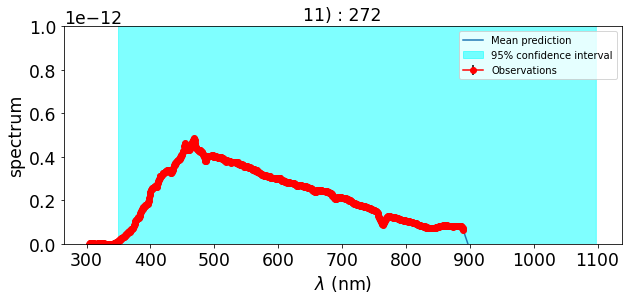

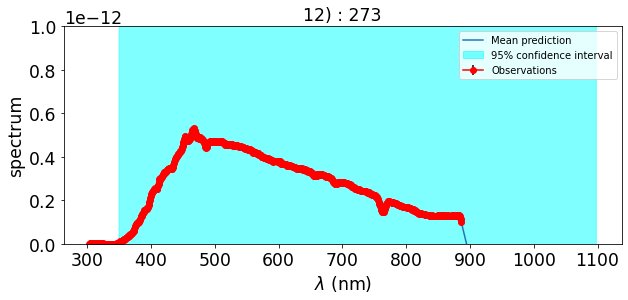

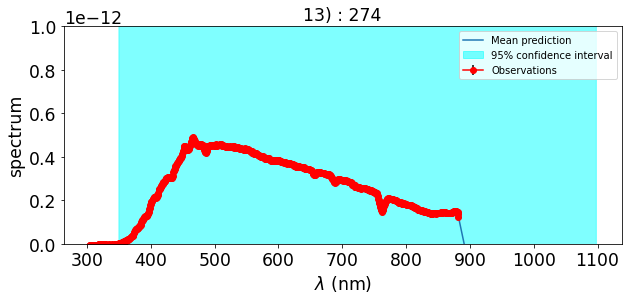

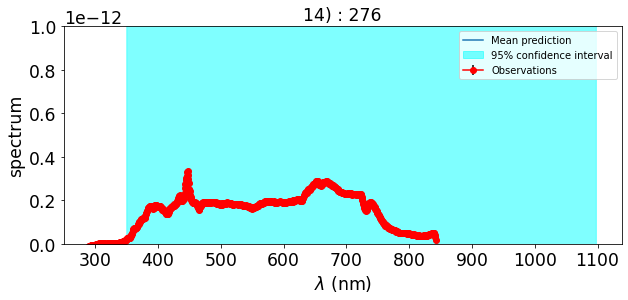

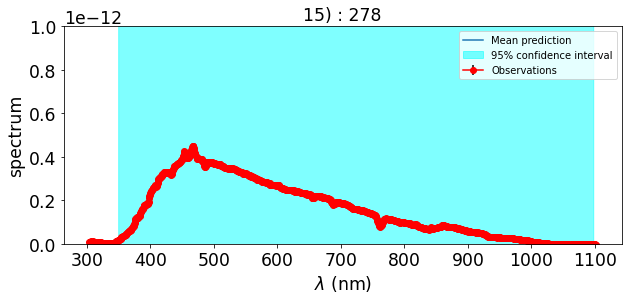

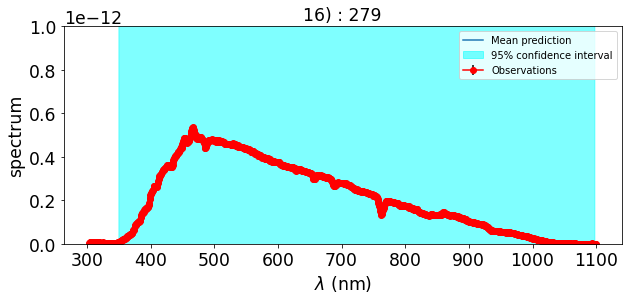

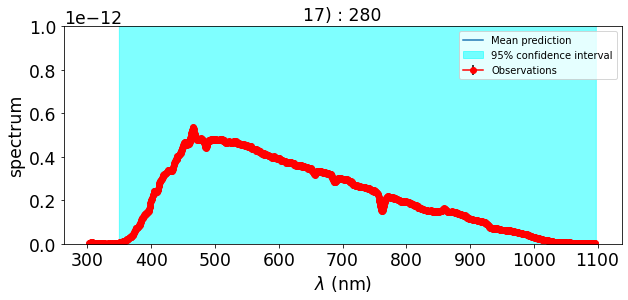

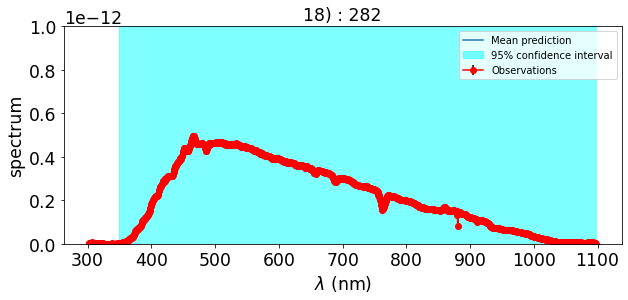

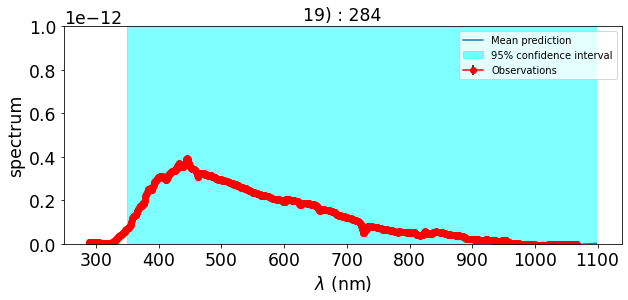

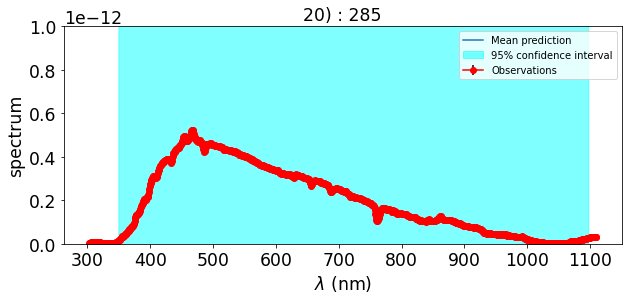

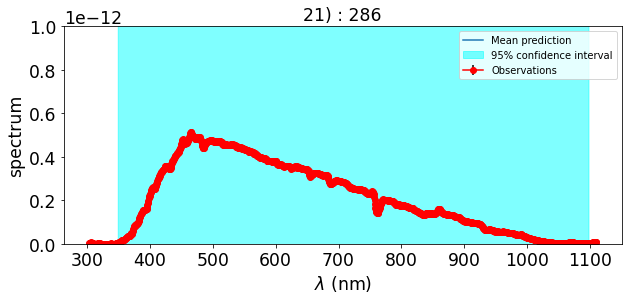

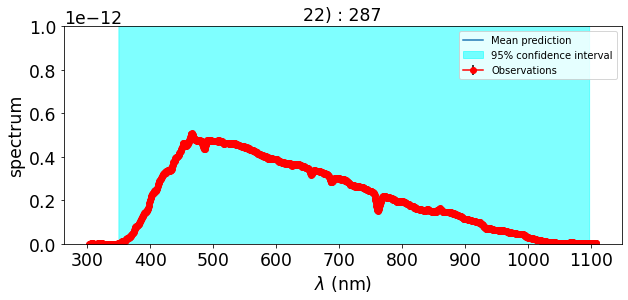

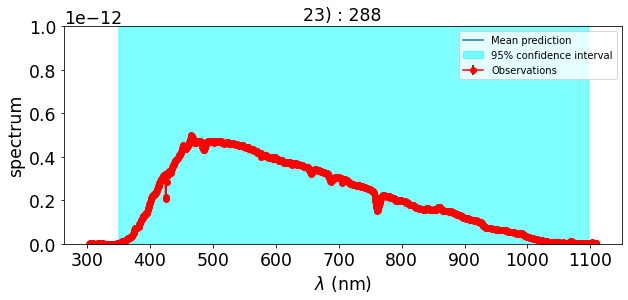

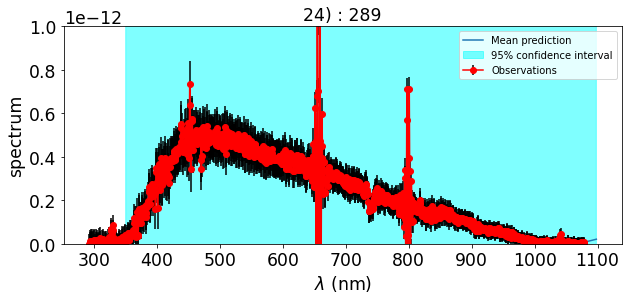

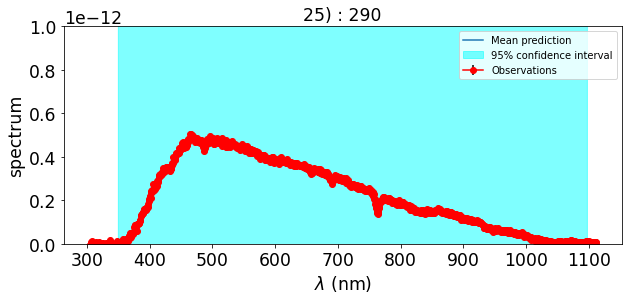

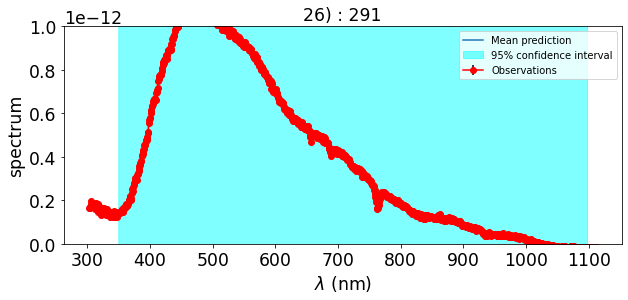

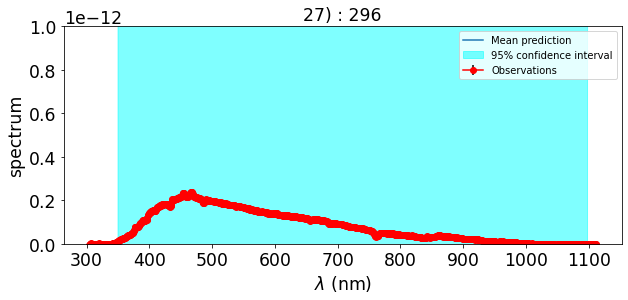

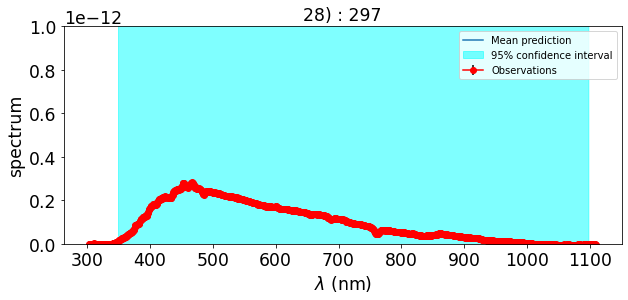

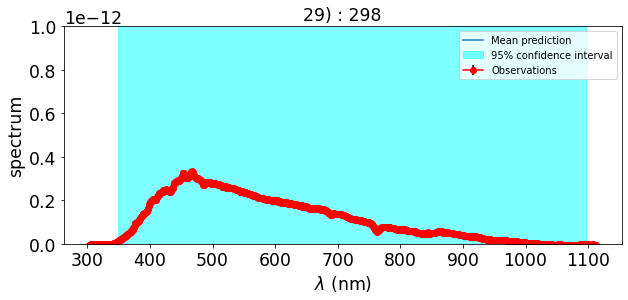

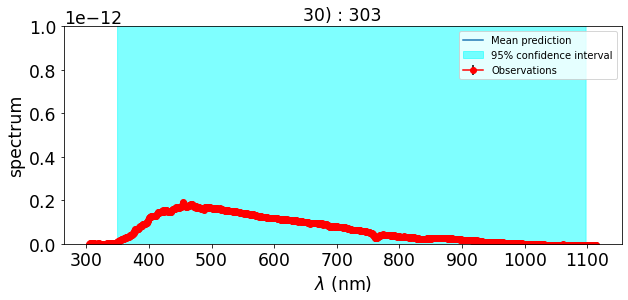

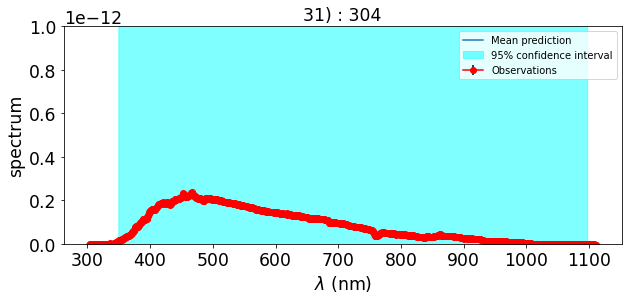

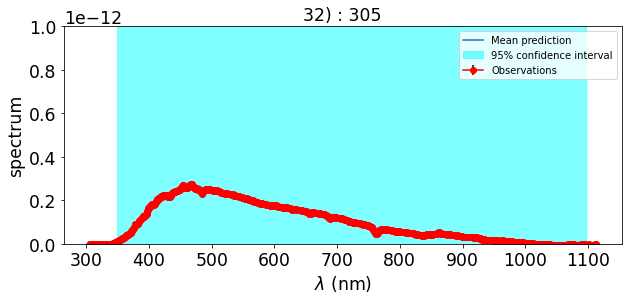

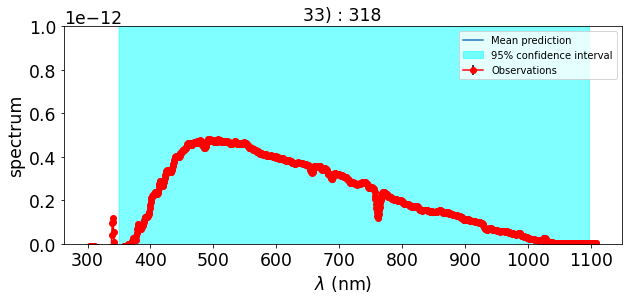

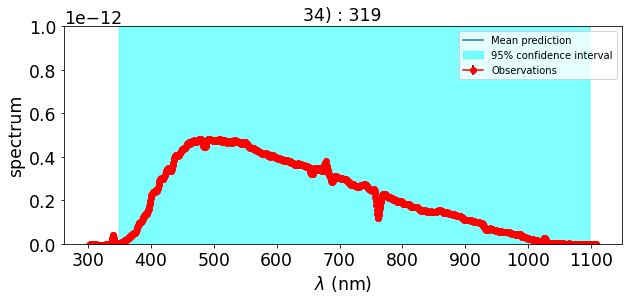

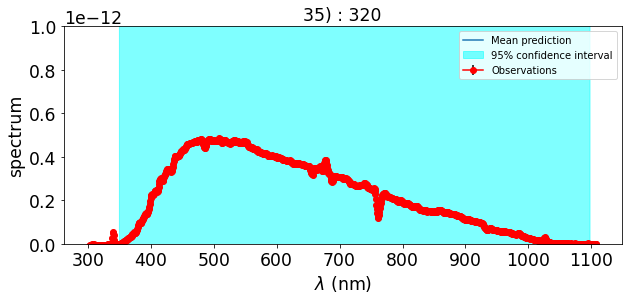

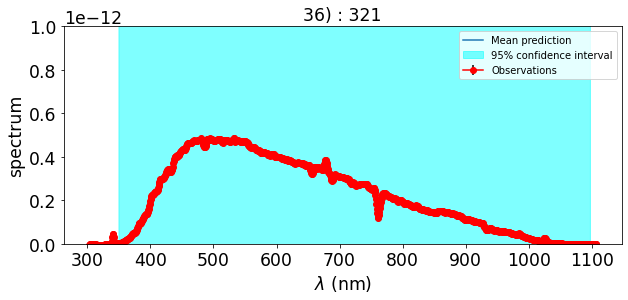

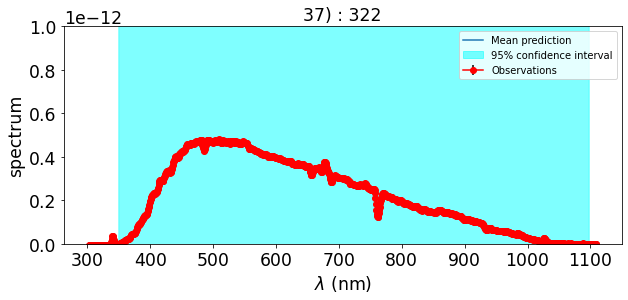

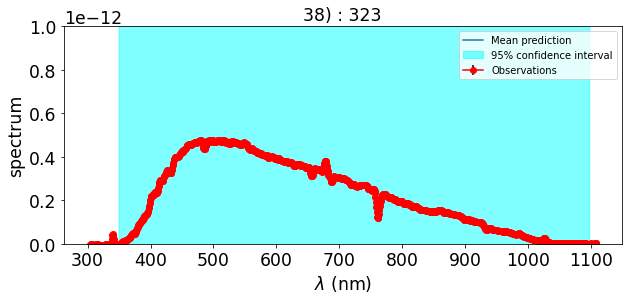

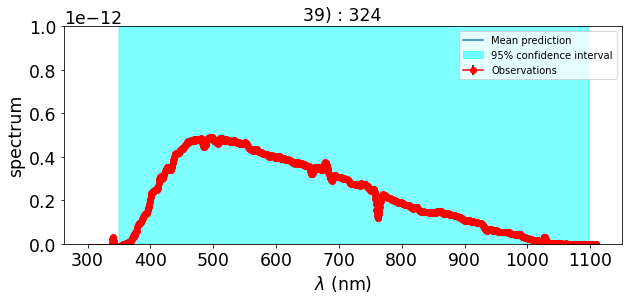

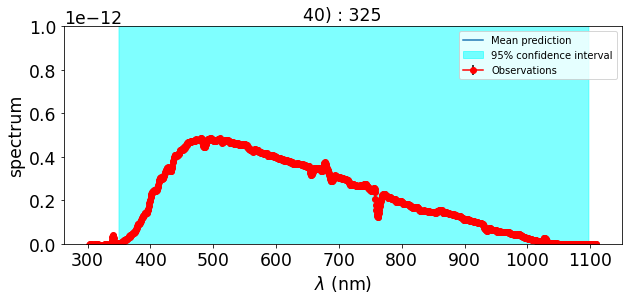

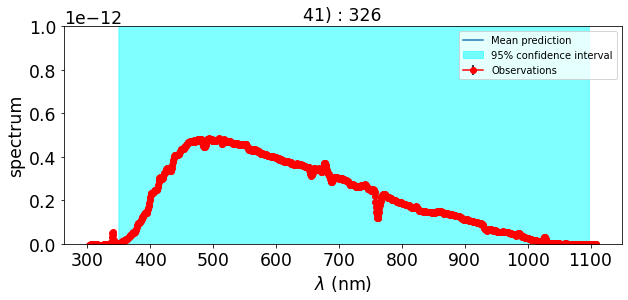

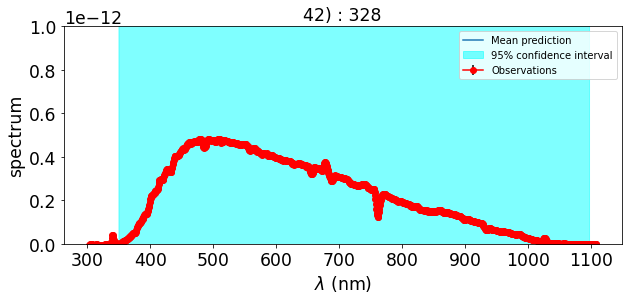

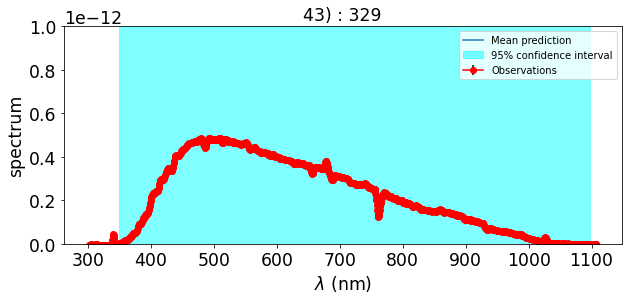

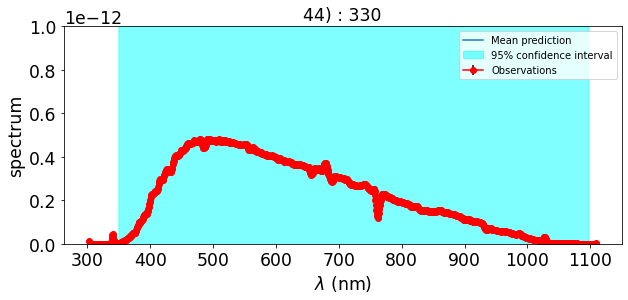

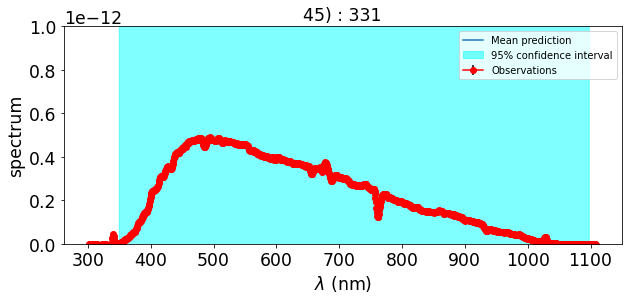

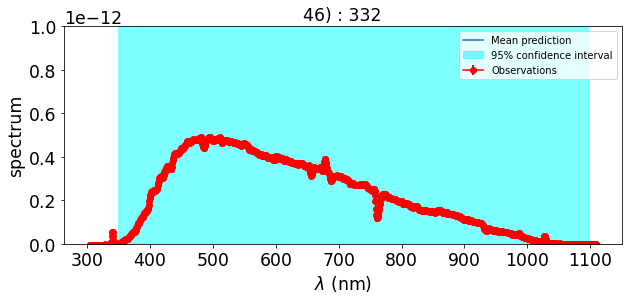

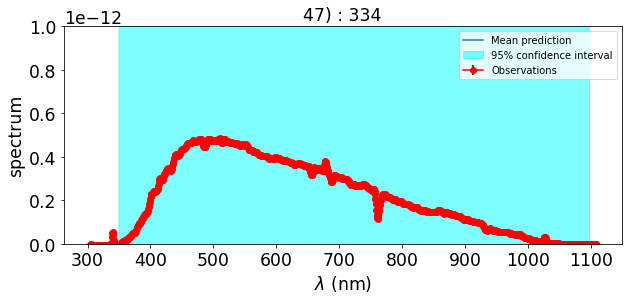

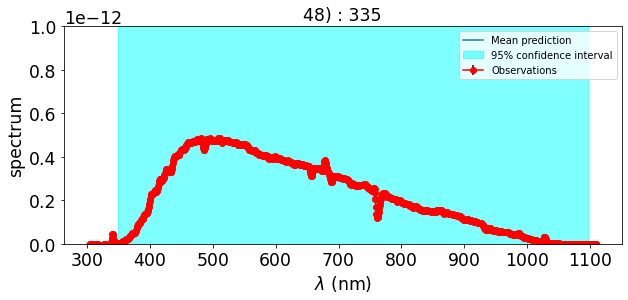

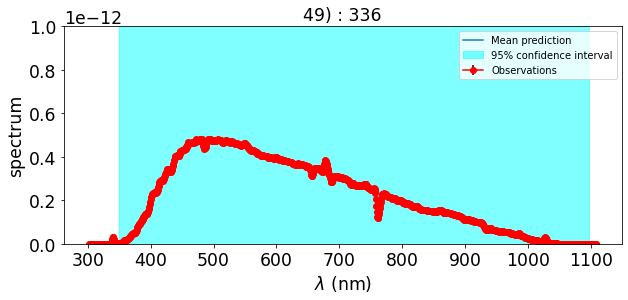

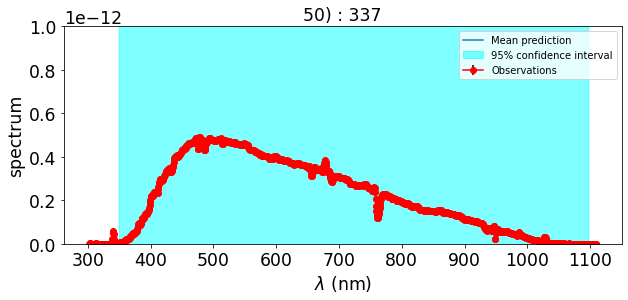

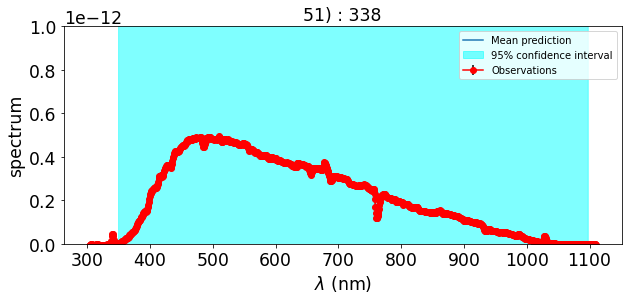

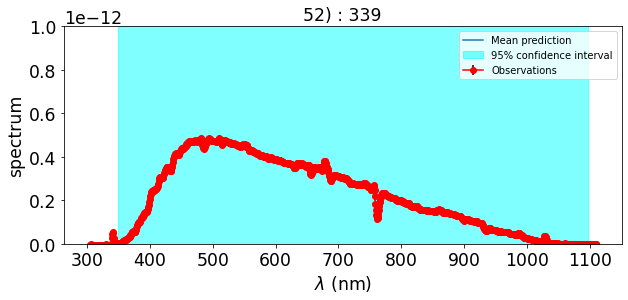

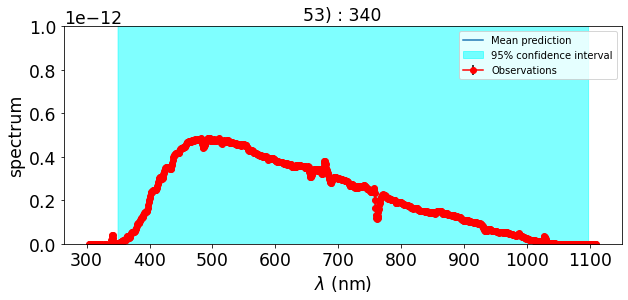

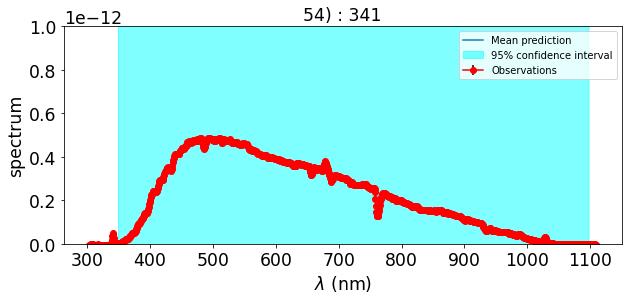

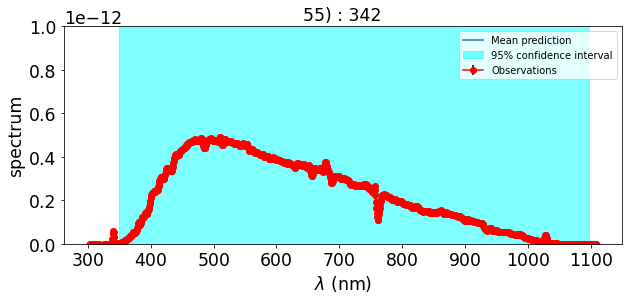

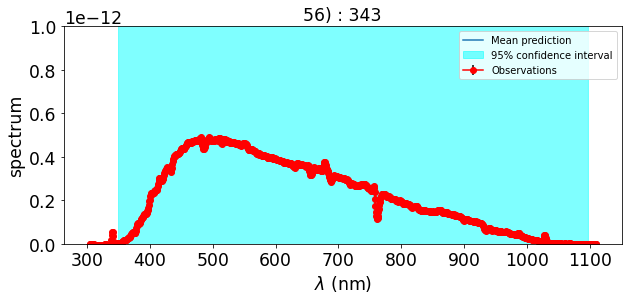

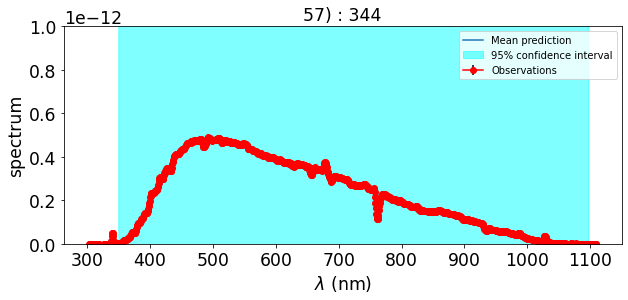

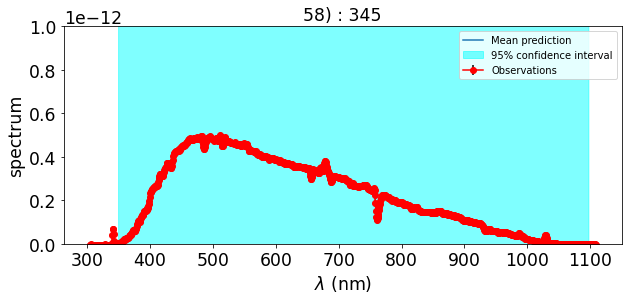

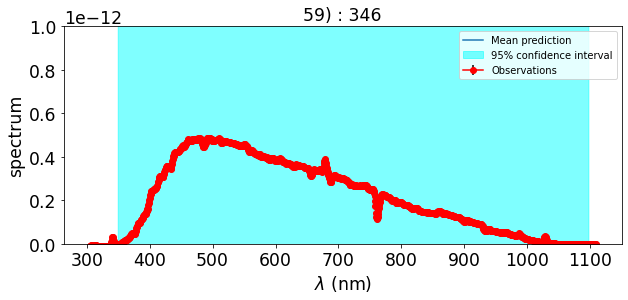

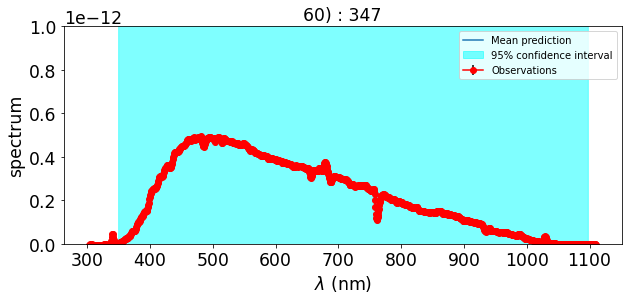

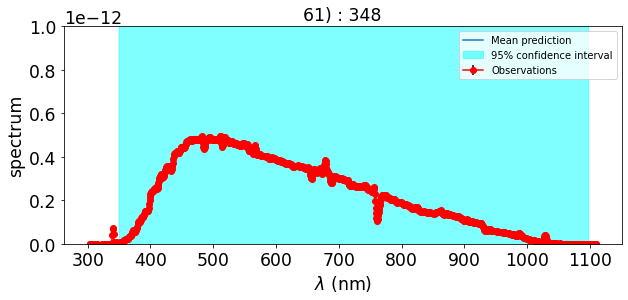

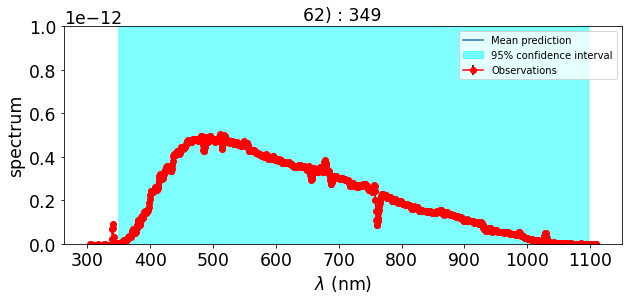

In [60]:

idx_sel=0
for filename in list_of_filenames:
    
         
    item  = data_dict[filename]
    lambdas = np.array(item['all_lambdas'])
    fluxes  = np.array(item['all_fluxes'])
    fluxes_err = np.array(item['all_fluxes_err'])
    label = int(item['number'])
    
     
    plotfitGPSpectrum(lambdas,fluxes,fluxes_err)
    plt.title(f"{idx_sel}) : {label}")
    idx_sel+=1
    
  
plt.show()
    